## 「ベイズ推論による機械学習入門」P.133 ポアソン混合モデルにおける変分推論

In [1]:
using Distributions
using Plots
using StatsBase
using SpecialFunctions: digamma

const ψ = digamma

digamma (generic function with 2 methods)

## 真のモデル

In [2]:
λ_true = [10.0, 25.0, 40.0]
π_true = [0.35, 0.3, 0.35]
true_model = MixtureModel([Poisson(λ) for λ in λ_true], π_true)

MixtureModel{Poisson{Float64}}(K = 3)
components[1] (prior = 0.3500): Poisson{Float64}(λ=10.0)
components[2] (prior = 0.3000): Poisson{Float64}(λ=25.0)
components[3] (prior = 0.3500): Poisson{Float64}(λ=40.0)


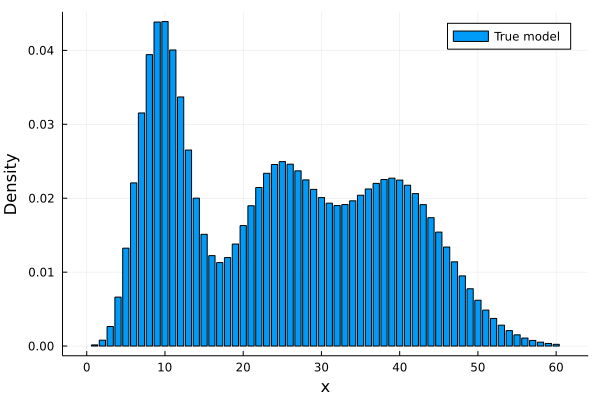

In [3]:
bar(x -> pdf(true_model, x), 1:60, label="True model", xlabel="x", ylabel="Density")

## 観測データを生成

潜在変数Sを生成し、各データに割り当てられたクラスタに従って観測データXを生成する。

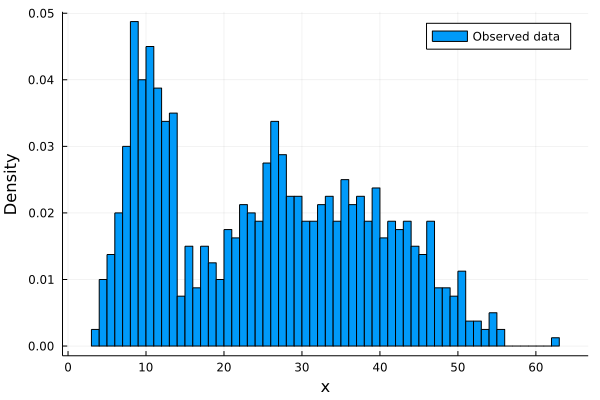

In [6]:
N = 800
mult_obs = Multinomial(1, π_true)
S_obs = rand(mult_obs, N)
cluster_num = mapslices(argmax, S_obs, dims=1)

data = Float64[]
for (idx, val) in enumerate(λ_true)
    n = count(cluster_num .== idx)
    poi_obs = Poisson(val)
    data = vcat(data, rand(poi_obs, n))
end

bins = 80
histogram(data; bins, label="Observed data", xlabel="x", ylabel="Density", norm=:pdf)

## 変分推論

In [ ]:
N = 800
K = 3
max_iter = 100

λ_sample = zeros(max_iter+1, K)
π_sample = zeros(max_iter+1, K)

λ_sample[1, :] = rand(K) .* (maximum(data) - minimum(data)) .+ minimum(data)
p = rand(K)
π_sample[1, :] = p ./ sum(p)
â = ones(K)
b̂ = ones(K)
α̂ = ones(K)

In [9]:
N = 800
K = 3
max_iter = 100

λ_sample = zeros(max_iter+1, K)
π_sample = zeros(max_iter+1, K)

λ_sample[1, :] = rand(K) .* (maximum(data) - minimum(data)) .+ minimum(data)
p = rand(K)
π_sample[1, :] = p ./ sum(p)
â = ones(K)
b̂ = ones(K)
α̂ = ones(K)

for i in 1:max_iter
    # 潜在変数の事後分布のパラメータを計算
    η_ = exp.(data' .* log.(λ_sample[i, :]) .- λ_sample[i, :] .+ π_sample[i, :]) # \eta + <TAB>
    η = η_ ./ sum(η_, dims=1) # 正規化
    s_sample = zeros(K, N)
    # 潜在変数をサンプル
    for n in 1:N
        cat = Multinomial(1, η[:, n])
        s_sample[:, n] = rand(cat, 1)
    end
　　　
    # λの事後分布のパラメータを計算
    â += sum(s_sample .* data', dims=2)
    b̂ += sum(s_sample, dims=2)
    # λをサンプル
    for k in 1:K
        gam = Gamma(â[k], 1 ./ b̂[k])
        λ_sample[i+1, k] = rand(gam, 1)[1]
    end
　　
    # πの事後分布のパラメータを計算
    α̂ += sum(s_sample, dims=2)
    # πをサンプル
    dir = Dirichlet(α̂[:])
    π_sample[i+1, :] = rand(dir, 1)
    
    if i % 10 == 1
        println("iteration: $i")
    end
end

iteration: 1
iteration: 11
iteration: 21
iteration: 31
iteration: 41
iteration: 51
iteration: 61
iteration: 71
iteration: 81
iteration: 91


## サンプルしたパラメータを使って分布を確認

┌ Info: Saved animation to 
│   fn = /Users/akifumiabe/Julia/BayesMLBook/poisson.gif
└ @ Plots /Users/akifumiabe/.julia/packages/Plots/T6yvp/src/animation.jl:114


Plots.AnimatedGif("/Users/akifumiabe/Julia/BayesMLBook/poisson.gif")
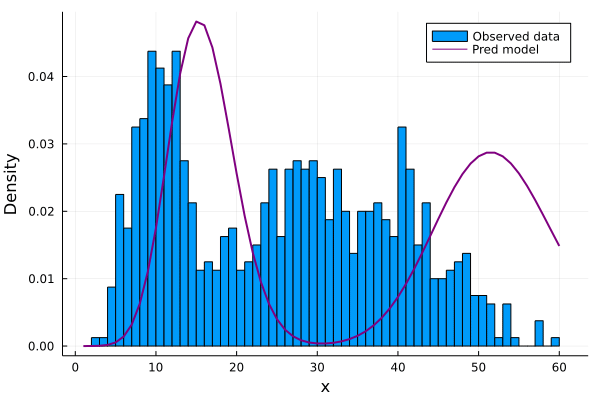

In [10]:
xs = 1:60
anim = @animate for i in 1:max_iter
    p = histogram(data; bins, norm=:pdf, label="Observed data", xlabel="x", ylabel="Density")
    d = MixtureModel([Poisson(λ) for λ in λ_sample[i, :]], π_sample[i, :])
    p = plot!(xs, pdf(d, xs), label="Pred model", linewidth=2, color="purple")
end

gif(anim, "poisson.gif", fps=10)